In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
from datetime import timedelta, date
import time
from yahoo_fin.options import *
import yfinance as yf
from pandas import ExcelWriter
from yahoo_fin import stock_info as si
from arch import arch_model
import math
import random
from scipy.stats import norm
from pandas.plotting import register_matplotlib_converters
import mplfinance as mpf
from numba import jit
from scipy.optimize import minimize
from scipy.optimize import leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
register_matplotlib_converters()
yf.pdr_override()

class Black_Sholes_Call:

    def call_delta(
        self, asset_price, strike_price,
        time_to_expiration,risk_free_rate,sigma
            ):
        time_to_expiration = np.array(time_to_expiration)
        asset_volatility = np.array(sigma)
        asset_price = np.array(asset_price)
        strike_price = np.array(strike_price)
        risk_free_rate = np.array(risk_free_rate)
        b = np.exp(-risk_free_rate*time_to_expiration)
        x1 = np.log(asset_price/(strike_price)) + risk_free_rate + .5*(asset_volatility**2)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1

    def call_price(
        self, asset_price, strike_price,
        time_to_expiration, risk_free_rate,sigma
            ):
        time_to_expiration = np.array(time_to_expiration)
        asset_volatility = np.array(sigma)
        asset_price = np.array(asset_price)
        strike_price = np.array(strike_price)
        risk_free_rate = np.array(risk_free_rate)
        b  = np.exp(-risk_free_rate*time_to_expiration)
        x1 = np.log(asset_price/strike_price)+(risk_free_rate + .5*(asset_volatility**2))*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = np.log(asset_price/strike_price) + (risk_free_rate -.5*(asset_volatility**2))*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1-z2
        
    def __init__(
        self, asset_price, strike_price,
        time_to_expiration, risk_free_rate,sigma):
        self.asset_price = asset_price
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, strike_price, time_to_expiration, risk_free_rate,sigma)
        self.delta = self.call_delta(asset_price, strike_price, time_to_expiration, risk_free_rate,sigma)

In [2]:
def Local_Vola_surface(asset_price, strike_price,
        time_to_expiration, risk_free_rate,sigma):
    dt = 0.009259
    dK = 0.69
    H = pd.DataFrame()
    C_kk = (Black_Sholes_Call(asset_price,strike_price + dK ,time_to_expiration,interest_rates,sigma).price - 2 * Black_Sholes_Call(asset_price,strike_price,time_to_expiration,interest_rates,sigma).price +  Black_Sholes_Call(asset_price,strike_price - dK ,time_to_expiration,interest_rates,sigma).price)/(2 * dK**2)
    C_t = (Black_Sholes_Call(asset_price,strike_price,time_to_expiration + dt,interest_rates,sigma).price - Black_Sholes_Call(asset_price,strike_price,time_to_expiration - dt,interest_rates,sigma).price)/(dt)
    Local_vol = np.sqrt(2*C_t/((strike_price**2)*C_kk))
    return Local_vol
    

In [3]:
import datetime 
from datetime import date
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2  
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(date(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360
S0 = 4163.26

In [4]:
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM
OPTION EXPIRY DATE,,,,,,,
2021-05-21,0.3571,924.30,931.10,3250.0,6.80,927.700,0.097222
2021-05-21,0.2903,628.00,633.90,3550.0,5.90,630.950,0.097222
2021-05-21,0.3329,824.90,831.70,3350.0,6.80,828.300,0.097222
2021-05-21,0.1582,158.10,161.60,4050.0,3.50,159.850,0.097222
2021-05-21,0.1873,245.10,249.50,3950.0,4.40,247.300,0.097222
2021-05-21,0.1135,1.90,2.15,4450.0,0.25,2.025,0.097222
2021-05-21,0.2036,337.40,342.30,3850.0,4.90,339.850,0.097222
2021-05-21,0.2367,432.70,437.80,3750.0,5.10,435.250,0.097222
2021-05-21,0.1366,82.90,84.40,4150.0,1.50,83.650,0.097222


In [5]:
from scipy import optimize
from scipy.optimize import minimize
import scipy
import pandas as pd

In [6]:
def Minim(X,args):
    Price,interest_rates,strike_price,TTM,asset_price = args
    C_BS = Black_Sholes_Call(asset_price,strike_price,TTM,interest_rates,X).price
    RE = C_BS - Price
    return RE

In [7]:
L['ImpliedVola']=0
i = 0
H = {}
for m in range(len(L)):
    args = [L['Mid Price'].values[m],0,L['Strikes'].values[m],L['TTM'].values[m],S0]
    x_0 = 0.01
    try:
        res = optimize.brentq(Minim,1e-5,10000,args,maxiter=10000)
    except:
        res = np.nan
    H[m] = res 

In [8]:
L['ImpliedVola']=H.values()
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM,ImpliedVola
OPTION EXPIRY DATE,,,,,,,,
2021-05-21,0.3571,924.30,931.10,3250.0,6.80,927.700,0.097222,0.505910
2021-05-21,0.2903,628.00,633.90,3550.0,5.90,630.950,0.097222,0.374106
2021-05-21,0.3329,824.90,831.70,3350.0,6.80,828.300,0.097222,0.459381
2021-05-21,0.1582,158.10,161.60,4050.0,3.50,159.850,0.097222,0.180889
2021-05-21,0.1873,245.10,249.50,3950.0,4.40,247.300,0.097222,0.216246
2021-05-21,0.1135,1.90,2.15,4450.0,0.25,2.025,0.097222,0.116249
2021-05-21,0.2036,337.40,342.30,3850.0,4.90,339.850,0.097222,0.252563
2021-05-21,0.2367,432.70,437.80,3750.0,5.10,435.250,0.097222,0.290356
2021-05-21,0.1366,82.90,84.40,4150.0,1.50,83.650,0.097222,0.148621


In [9]:
def Local_Vola_surface(asset_price, strike_price,
        time_to_expiration, risk_free_rate,sigma):
    dt = pd.DataFrame(time_to_expiration).diff().mean()[0]
    dK = pd.DataFrame(strike_price).diff().mean()[0]
    if np.sum(dt) == 0 and np.sum(dK) ==0:
        dt = 1/252
        dK = 5
    else:
        dt = dt
        dK = dK
    C_kk = (Black_Sholes_Call(asset_price,strike_price + dK ,time_to_expiration,risk_free_rate,sigma).price  \
            - 2 * Black_Sholes_Call(asset_price,strike_price,time_to_expiration,risk_free_rate,sigma).price \
            +  Black_Sholes_Call(asset_price,strike_price - dK ,time_to_expiration,risk_free_rate,sigma).price)/(dK**2)
    C_t = (Black_Sholes_Call(asset_price,strike_price,time_to_expiration + dt,risk_free_rate,sigma).price \
           - Black_Sholes_Call(asset_price,strike_price,time_to_expiration - dt,risk_free_rate,sigma).price)/(2*dt)
    C_k = (Black_Sholes_Call(asset_price,strike_price + dK,time_to_expiration,risk_free_rate,sigma).price \
           - Black_Sholes_Call(asset_price,strike_price - dK,time_to_expiration,risk_free_rate,sigma).price)/(2*dK)
    
    C = Black_Sholes_Call(asset_price,strike_price,time_to_expiration,risk_free_rate,sigma).price
    
    Local_vol = np.sqrt(2*(C_t +  risk_free_rate * strike_price * C_k  - risk_free_rate * C )/((strike_price**2)*C_kk))
    
    return Local_vol

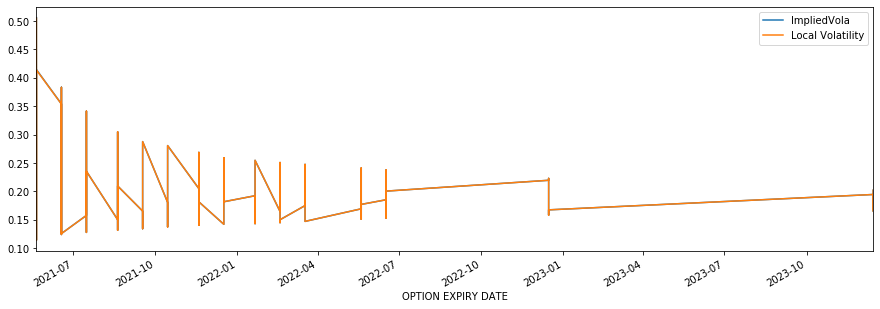

In [10]:
Local_sigma = Local_Vola_surface(S0, L.Strikes.values ,L.TTM.values,0,L['ImpliedVola'].values)
L['Local Volatility'] = Local_sigma
(L[['ImpliedVola','Local Volatility']]).plot(figsize=(15,5))
plt.show()

In [11]:
def Gamma_compilator(S,K,vol,dt,r):
    d1 = (np.log(S/K) + (r + .5 * vol**2 )*dt)/(vol*np.sqrt(dt))
    Gamma = norm.pdf(d1)/(S*vol*np.sqrt(dt))
    return Gamma 

In [12]:
L['Gamma'] = Gamma_compilator(S0,L.Strikes.values,L['ImpliedVola'].values,L.TTM.values,0)
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM,ImpliedVola,Local Volatility,Gamma
OPTION EXPIRY DATE,,,,,,,,,,
2021-05-21,0.3571,924.30,931.10,3250.0,6.80,927.700,0.097222,0.505910,0.504913,0.000156
2021-05-21,0.2903,628.00,633.90,3550.0,5.90,630.950,0.097222,0.374106,0.373496,0.000298
2021-05-21,0.3329,824.90,831.70,3350.0,6.80,828.300,0.097222,0.459381,0.458507,0.000189
2021-05-21,0.1582,158.10,161.60,4050.0,3.50,159.850,0.097222,0.180889,0.180994,0.001486
2021-05-21,0.1873,245.10,249.50,3950.0,4.40,247.300,0.097222,0.216246,0.216226,0.001021
2021-05-21,0.1135,1.90,2.15,4450.0,0.25,2.025,0.097222,0.116249,0.116001,0.000505
2021-05-21,0.2036,337.40,342.30,3850.0,4.90,339.850,0.097222,0.252563,0.252393,0.000714
2021-05-21,0.2367,432.70,437.80,3750.0,5.10,435.250,0.097222,0.290356,0.290032,0.000515
2021-05-21,0.1366,82.90,84.40,4150.0,1.50,83.650,0.097222,0.148621,0.148779,0.002059


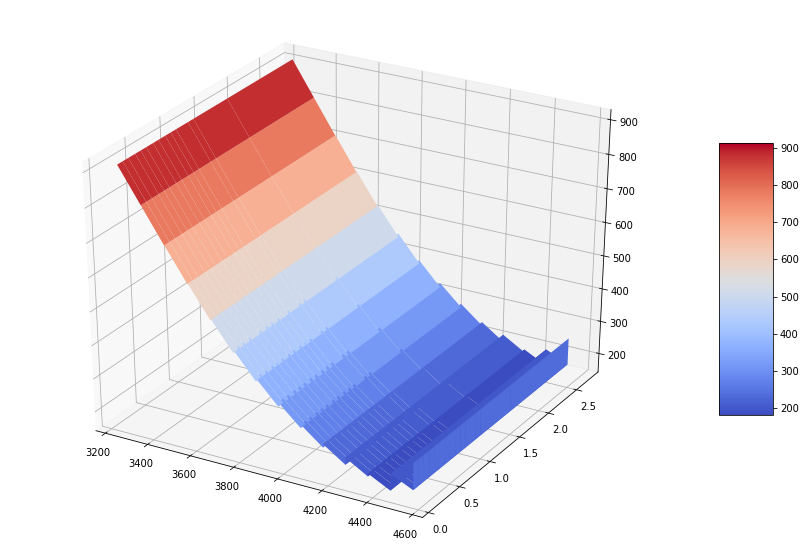

In [13]:
# Creates a 1D array of all possible x and y coordinates
x_coords = L['Strikes'].sort_values().values
y_coords = L['TTM'].sort_values().values
interest_rates = 0

# Creates 2D array with all possible combinations of x and y coordinates,
# so x_grid.shape = (100, 100) and y_grid.shape = (100, 100)
[x_grid, y_grid] = np.meshgrid(x_coords, y_coords)

# Evaluates z at all grid points
z_grid = Black_Sholes_Call(S0,x_grid,y_coords,interest_rates,0.148779).price #ATM

# Plotting
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid,y_grid,z_grid,cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [14]:
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM,ImpliedVola,Local Volatility,Gamma
OPTION EXPIRY DATE,,,,,,,,,,
2021-05-21,0.3571,924.30,931.10,3250.0,6.80,927.700,0.097222,0.505910,0.504913,0.000156
2021-05-21,0.2903,628.00,633.90,3550.0,5.90,630.950,0.097222,0.374106,0.373496,0.000298
2021-05-21,0.3329,824.90,831.70,3350.0,6.80,828.300,0.097222,0.459381,0.458507,0.000189
2021-05-21,0.1582,158.10,161.60,4050.0,3.50,159.850,0.097222,0.180889,0.180994,0.001486
2021-05-21,0.1873,245.10,249.50,3950.0,4.40,247.300,0.097222,0.216246,0.216226,0.001021
2021-05-21,0.1135,1.90,2.15,4450.0,0.25,2.025,0.097222,0.116249,0.116001,0.000505
2021-05-21,0.2036,337.40,342.30,3850.0,4.90,339.850,0.097222,0.252563,0.252393,0.000714
2021-05-21,0.2367,432.70,437.80,3750.0,5.10,435.250,0.097222,0.290356,0.290032,0.000515
2021-05-21,0.1366,82.90,84.40,4150.0,1.50,83.650,0.097222,0.148621,0.148779,0.002059


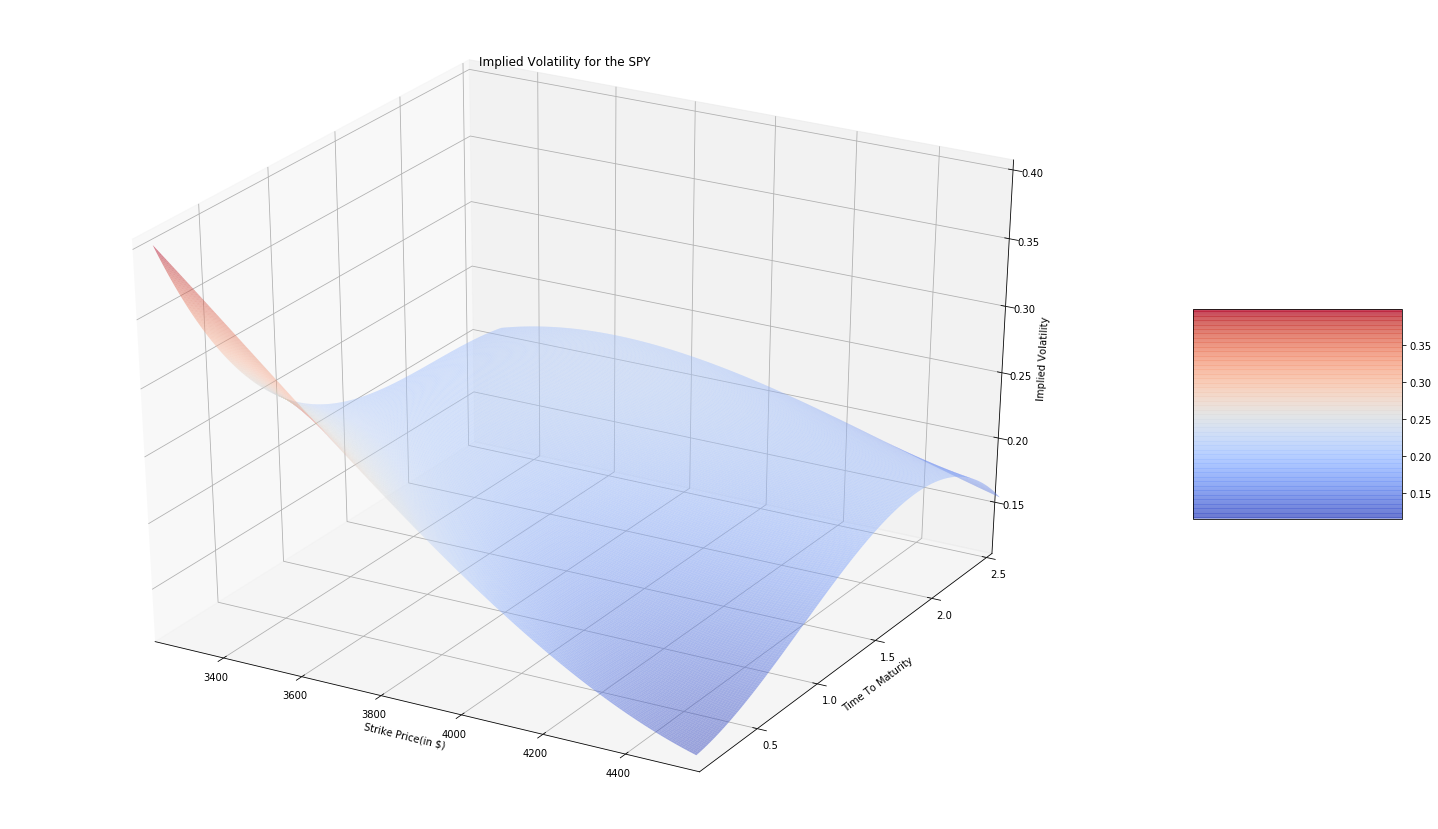

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# The training set
datapoints = L[['Strikes','TTM','ImpliedVola']].sort_values(by='Strikes').values
X = datapoints[:,0:2]
Y = datapoints[:,-1]

# 3 degree polynomial features

deg_of_poly = 3
poly = PolynomialFeatures(degree=deg_of_poly)
X_ = poly.fit_transform(X)
# Fit linear model
clf = linear_model.LinearRegression()
clf.fit(X_, Y)

# The test set, or plotting set
N = len(datapoints)
#Length = 1000
predict_x0, predict_x1 = np.meshgrid(np.linspace(int(L['Strikes'].min()), int(L['Strikes'].max()), N), #int(M['Strike'].max())
                                     np.linspace(L['TTM'].min(),L['TTM'].max(), N))
predict_x = np.concatenate((predict_x0.reshape(-1, 1), 
                            predict_x1.reshape(-1, 1)), 
                           axis=1)
predict_x_ = poly.fit_transform(predict_x)
predict_y = clf.predict(predict_x_)

# Plot
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(projection='3d')
surf = ax1.plot_surface(predict_x0, predict_x1, predict_y.reshape(predict_x0.shape), 
                        rstride=1, cstride=1,cmap=cm.coolwarm, alpha=0.5)

#ax1.scatter(datapoints[:, 0], datapoints[:, 1], datapoints[:, 2], c='b', marker='o')

ax1.set_xlim(int(L['Strikes'].min()), int(L['Strikes'].max()))
ax1.set_ylim(1/12,2.5)
fig.colorbar(surf, ax=ax1, shrink=0.50, aspect=1)
ax1.set_ylabel('Time To Maturity')
ax1.set_title('Implied Volatility for the SPY')
ax1.set_xlabel('Strike Price(in $)')
ax1.set_zlabel('Implied Volatility')
plt.show()

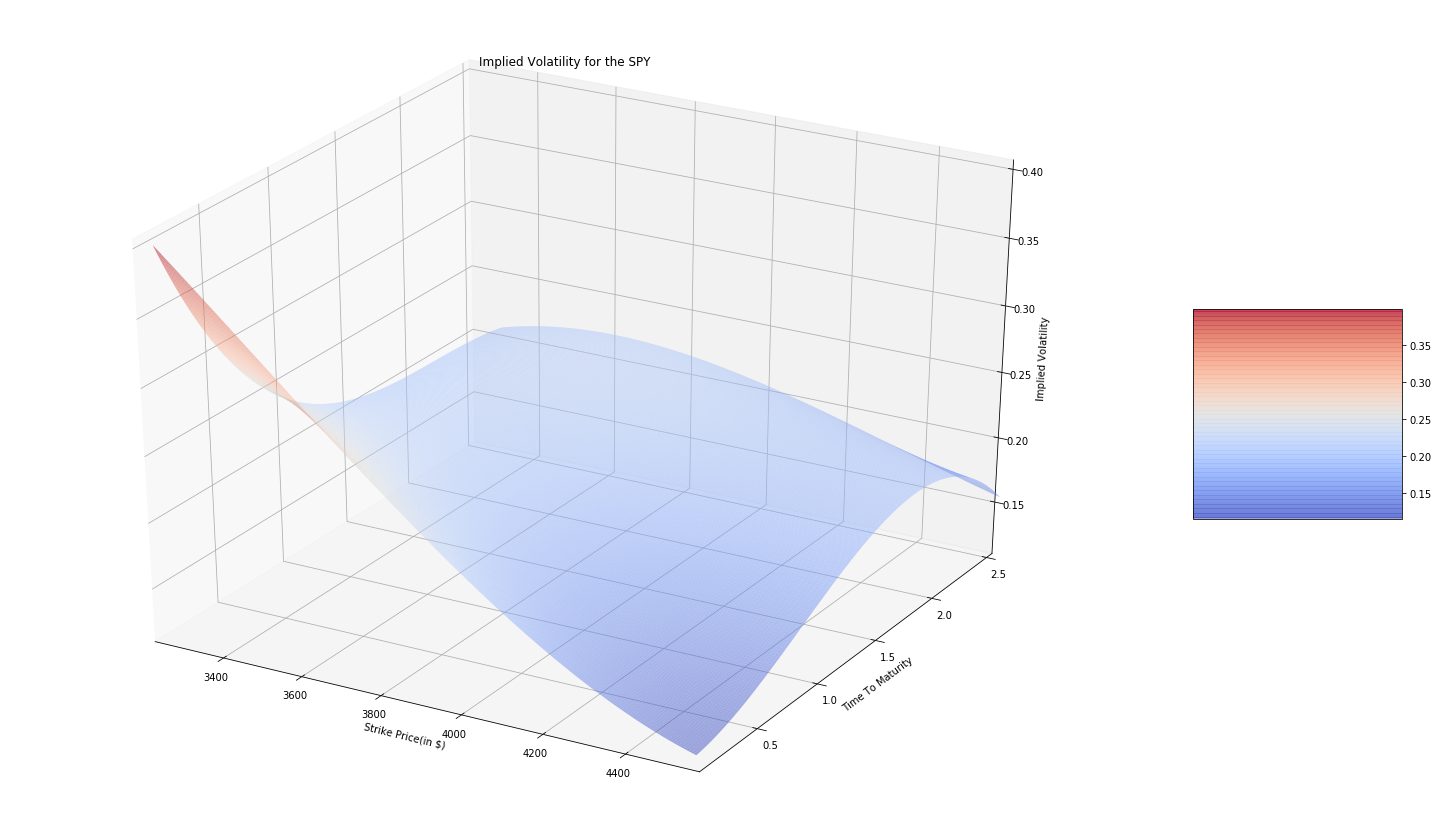

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# The training set
datapoints = L[['Strikes','TTM','Local Volatility']].sort_values(by='Strikes').values
X = datapoints[:,0:2]
Y = datapoints[:,-1]

# 3 degree polynomial features

deg_of_poly = 3
poly = PolynomialFeatures(degree=deg_of_poly)
X_ = poly.fit_transform(X)
# Fit linear model
clf = linear_model.LinearRegression()
clf.fit(X_, Y)

# The test set, or plotting set
N = len(datapoints)
#Length = 1000
predict_x0, predict_x1 = np.meshgrid(np.linspace(int(L['Strikes'].min()), int(L['Strikes'].max()), N), #int(M['Strike'].max())
                                     np.linspace(L['TTM'].min(),L['TTM'].max(), N))
predict_x = np.concatenate((predict_x0.reshape(-1, 1), 
                            predict_x1.reshape(-1, 1)), 
                           axis=1)
predict_x_ = poly.fit_transform(predict_x)
predict_y = clf.predict(predict_x_)

# Plot
fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(projection='3d')
surf = ax1.plot_surface(predict_x0, predict_x1, predict_y.reshape(predict_x0.shape), 
                        rstride=1, cstride=1,cmap=cm.coolwarm, alpha=0.5)

#ax1.scatter(datapoints[:, 0], datapoints[:, 1], datapoints[:, 2], c='b', marker='o')

ax1.set_xlim(int(L['Strikes'].min()), int(L['Strikes'].max()))
ax1.set_ylim(1/12,2.5)
fig.colorbar(surf, ax=ax1, shrink=0.50, aspect=1)
ax1.set_ylabel('Time To Maturity')
ax1.set_title('Implied Volatility for the SPY')
ax1.set_xlabel('Strike Price(in $)')
ax1.set_zlabel('Implied Volatility')
plt.show()

# Surfaces Using Gaussian Process

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


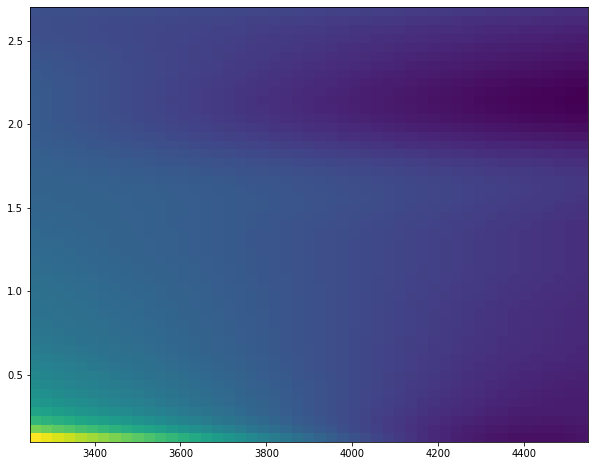

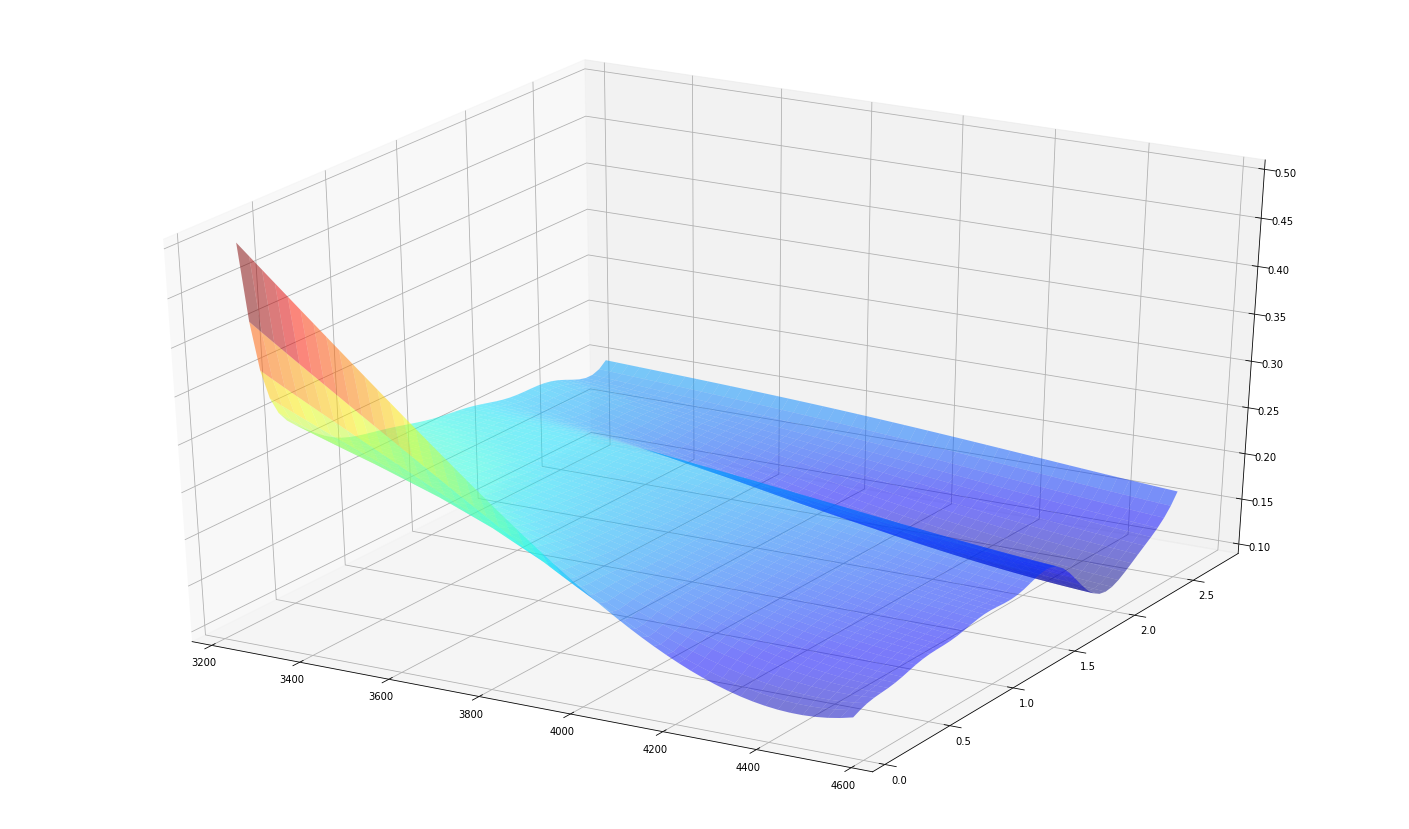

In [89]:
# The training set
from itertools import product
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

datapoints = L[['Strikes','TTM','ImpliedVola']].sort_values(by='Strikes').values
X = datapoints[:,0:2]
Y = datapoints[:,-1]

# The test set, or plotting set
N = len(datapoints)
#Length = 1000
# Input space
x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(0.0, (1e-3, 1e3)) + RBF([1,1]) + WhiteKernel(noise_level = np.var(X[:,1]))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, Y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)


fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(projection='3d')       
surf = ax1.plot_surface(X0p, X1p, Zp,rstride=1, cstride=1,cmap='jet', alpha=0.5)

plt.show()

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


MSE =  181.09214490089005 2500


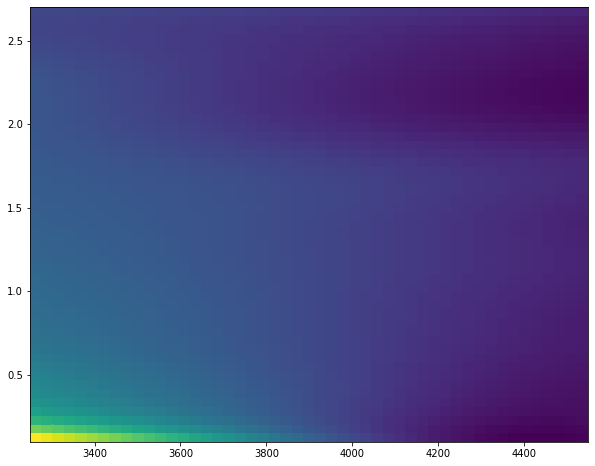

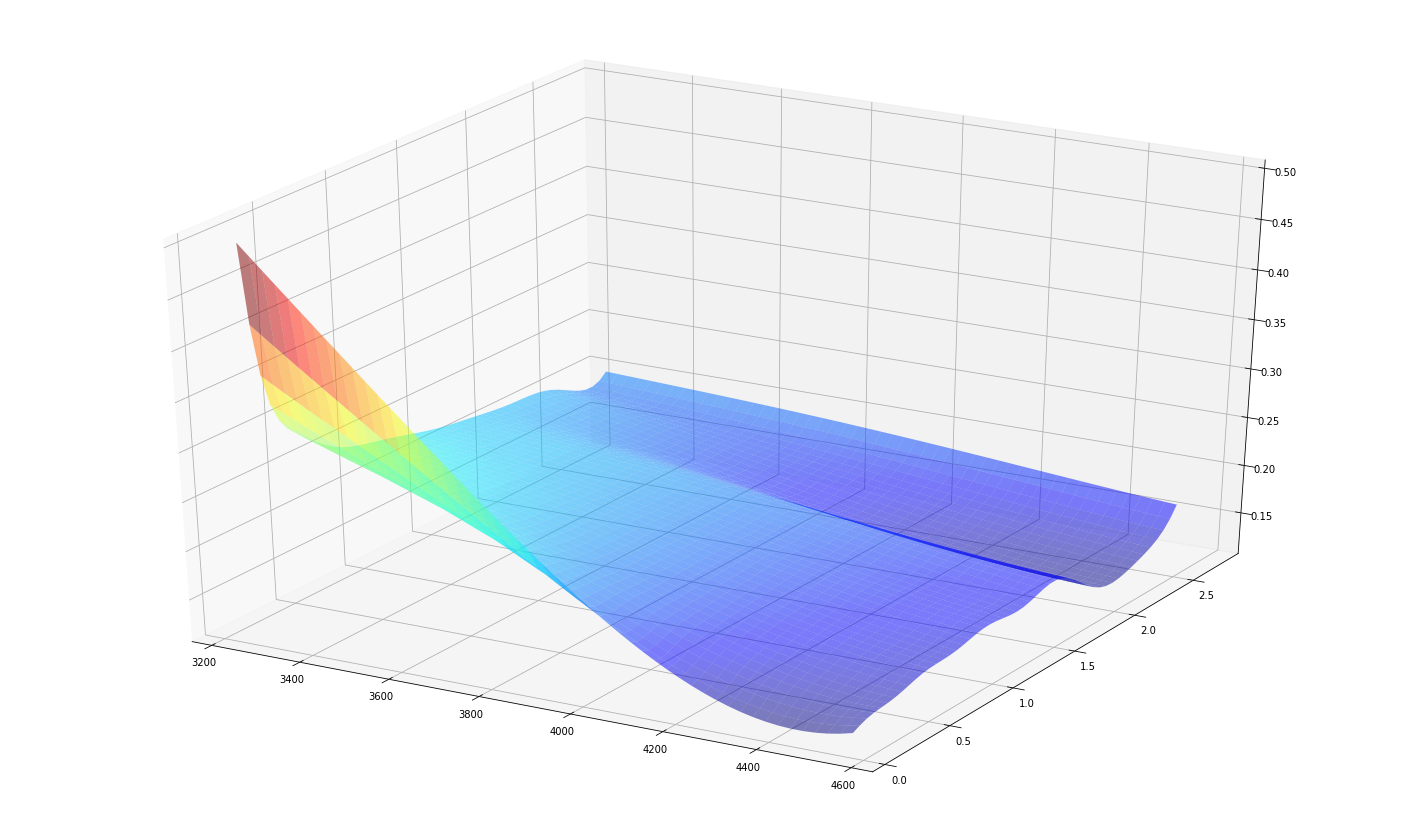

In [88]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# The training set
datapoints = L[['Strikes','TTM','Local Volatility']].sort_values(by='Strikes').values
X = datapoints[:,0:2]
Y = datapoints[:,-1]

# Gaussian Process

x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(0.0, (1e-3, 1e3)) + RBF([1,1]) + WhiteKernel(noise_level = np.var(X[:,1]))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, Y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

print('MSE = ',np.sum((MSE)**2),len(MSE))

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)


fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(projection='3d')       
surf = ax1.plot_surface(X0p, X1p, Zp,rstride=1, cstride=1,cmap='jet', alpha=0.5)

plt.show()

# Gamma

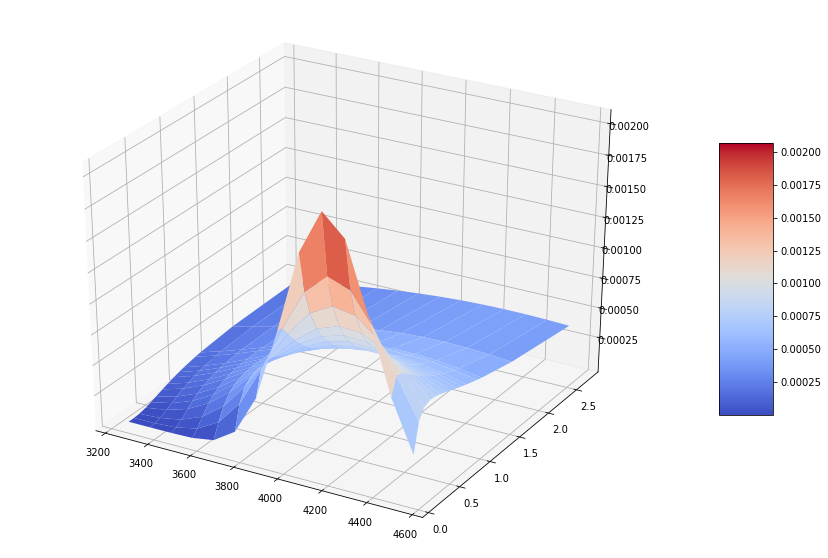

In [28]:
# Creates a 1D array of all possible x and y coordinates
x_coords = L['Strikes'].sort_values().values
y_coords = L['TTM'].sort_values().values

# Creates 2D array with all possible combinations of x and y coordinates,
# so x_grid.shape = (100, 100) and y_grid.shape = (100, 100)
[x_grid, y_grid] = np.meshgrid(x_coords, y_coords)

# Evaluates z at all grid points (S,K,Realized_sigma,dt,r)
z_grid = Gamma_compilator(S0,x_coords,0.148,y_grid,0)

# Plotting
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid,y_grid,z_grid,cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()